## 1.Import libraries
The required libraries for this notebook are pandas, sklearn, numpy and matplotlib.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
from tqdm.auto import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, canny
import imgaug.augmenters as iaa
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.feature_selection import SelectFromModel, SelectPercentile, f_classif
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, metrics

## 2.1 Edit label.csv data
Add column for binary label: 0 for no tumor, 1 for tumor

In [2]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


## 2.2 Add image data
Add image data in the form of an array to the label data and save it in a new pickle file so it does not need to run everytime

In [3]:
def create_binary(df):
    '''
    Inputs
        df: Label data.

    Return
        binary: List of binary labels - 0 if no tumor, 1 if tumor.
    '''

    binary = []
    for label in df['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

In [4]:
# data_path = './dataset/image'
# images = []
# for filename in tqdm(df['file_name']):
#     im = imread(os.path.join(data_path, filename), as_gray=True)
#     coeffs = pywt.dwt2(im, 'haar')
#     LL, (LH, HL, HH) = coeffs
#     # DWT transforms image to (256,256) from (516,516)
#     images.append(LL)

# # Index of images with no_tumor label
# noTumor_idx = df.index[df['label'] == 'no_tumor'].tolist()
# # List of images with no_tumor label
# images_noTumor = []
# for idx in tqdm(noTumor_idx):
#     images_noTumor.append(images[idx])

# seq1 = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     # Small gaussian blur with random sigma between 0 and 0.5.
#     # But we only blur about 50% of all images.
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     )
# ], random_order=True)

# seq2 = iaa.Sequential([
#     iaa.Flipud(0.5),  # vertical flips
#     # Small gaussian blur with random sigma between 0 and 0.5.
#     # But we only blur about 50% of all images.
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     )
# ], random_order=True)

# # Quadruple the no_tumor images
# images_aug_noTumor1 = seq1(images=images_noTumor)
# images_aug_noTumor2 = seq2(images=images_noTumor)

# # Concatenate the lists of image pixel data to form a new dataset with augmented images
# images_new = images + images_aug_noTumor1 + images_aug_noTumor2

In [5]:
def extract_hog(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

if os.path.exists('./dataset/label_taskA_hog.pkl'):
    print('The pickle file for Task A with hog features data already exists')
else:
    binary = create_binary(df)
    hog_features = extract_hog(images_new)
    
    label_taskA = pd.DataFrame(data = hog_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx) 
    label_taskA.to_pickle("./dataset/label_taskA_hog.pkl")

The pickle file for Task A with hog features data already exists


In [6]:
def extract_lbp(images_pixelData, numPoints):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    radius = 3

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

if os.path.exists('./dataset/label_taskA_lbp.pkl'):
    print('The pickle file for Task B with lbp features data already exists')
else:
    binary = create_binary(df)
    lbp_features = extract_lbp(images_new, 255)
    
    label_taskA = pd.DataFrame(data = lbp_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_lbp.pkl")

The pickle file for Task B with lbp features data already exists


In [7]:
def extract_canny(images_pixelData, sigma):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       canny_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    canny_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Compute the Canny filter for the image
        filtered_im = canny(images_pixelData[i], sigma=sigma).ravel()
        # filtered_im = filtered_im.ravel()

        canny_features.append(filtered_im)

    return canny_features

if os.path.exists('./dataset/label_taskA_canny.pkl'):
    print('The pickle file for Task B image data filtered with Canny filter already exists')
else:
    binary = create_binary(df)
    canny_features = extract_canny(images_new, 1)
    
    label_taskA = pd.DataFrame(data = canny_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_canny.pkl")

The pickle file for Task B image data filtered with Canny filter already exists


In [8]:
def extract_multidwt(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       multidwt: A list of Local Binary Pattern (LBP) features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        # Second level DWT
        coeffs = pywt.dwt2(images_pixelData[i], 'haar')
        LL, (LH, HL, HH) = coeffs
        # Third level DWT
        coeffs2 = pywt.dwt2(LL, 'haar')
        LL2, (LH2, HL2, HH2) = coeffs2

        multidwt.append(LL2.ravel())

    return multidwt

if os.path.exists('./dataset/label_taskA_multidwt.pkl'):
    print('The pickle file for Task B image data transformed by DWT three times already exists')
else:
    binary = create_binary(df)
    multidwt = extract_multidwt(images_new)
    
    label_taskA = pd.DataFrame(data = multidwt)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_multidwt.pkl")

The pickle file for Task B image data transformed by DWT three times already exists


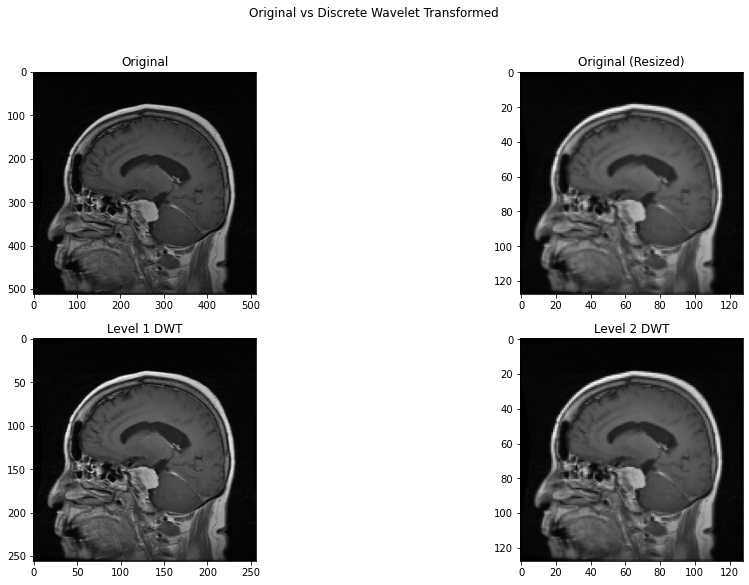

In [9]:
img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs
coeffs2 = pywt.dwt2(LL, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
fig.suptitle('Original vs Discrete Wavelet Transformed')
axs[0, 0].set_title('Original')
axs[0, 0].imshow(img, cmap=plt.cm.gray)
axs[0, 1].set_title('Original (Resized)')
axs[0, 1].imshow(resize(img, (128, 128)), cmap=plt.cm.gray)
axs[1, 0].set_title('Level 1 DWT')
axs[1, 0].imshow(LL, cmap=plt.cm.gray)
axs[1, 1].set_title('Level 2 DWT')
axs[1, 1].imshow(LL2, cmap=plt.cm.gray)

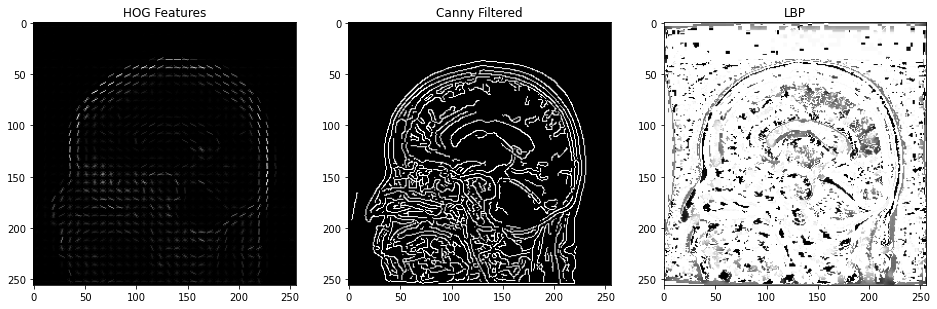

In [10]:
img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

fd, hog_img = hog(LL, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = True, block_norm='L2-Hys')

filtered_im = canny(LL, sigma=1)

lbp = local_binary_pattern(LL, 50, 8, method="uniform")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))
axs[0].set_title('HOG Features')
axs[0].imshow(hog_img, cmap=plt.cm.gray)

axs[1].set_title('Canny Filtered')
axs[1].imshow(filtered_im, cmap=plt.cm.gray)

axs[2].set_title('LBP')
axs[2].imshow(lbp, cmap=plt.cm.gray)

In [11]:
def PCAPredict(X_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        X_test: Testing dataset;
        k: Number of components to use.
        
    Return
        X_train_PCA: Training dataset after applying PCA to reduce its dimensions;
        X_test_PCA: Test dataset after applying PCA to reduce its dimensions.
    '''

    # the built-in function for PCA
    pca = PCA(k)
    
    # the built-in function to standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()

    # fit the algorithm with dataset
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca.fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train_scaled)
    X_test_PCA = pca.transform(X_test_scaled)
    
    return X_train_PCA, X_test_PCA

In [12]:
def feature_selection(X_train, X_test, y_train, select):
    if select == 'et':
        clf = ExtraTreesClassifier(n_estimators=100)
        clf = clf.fit(X_train, y_train)
        model = SelectFromModel(clf, prefit=True)
        X_train_new = model.transform(X_train)
        X_test_new = model.transform(X_test)
    elif select == 'rf':
        forest = RandomForestClassifier(random_state=0)
        forest.fit(X_train, y_train)
        model = SelectFromModel(forest, prefit=True)
        X_train_new = model.transform(X_train)
        X_test_new = model.transform(X_test)
    elif select == 'svc':
        lsvc = svm.LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
        model = SelectFromModel(lsvc, prefit=True)
        X_train_new = model.transform(X_train)
        X_test_new = model.transform(X_test)
    elif select == 'percent':
        model = SelectPercentile(percentile=50).fit(X_train, y_train)
        X_train_new = model.transform(X_train)
        X_test_new = model.transform(X_test)
 
    return X_train_new, X_test_new

In [18]:
feature = 'multidwt'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskA = pd.read_pickle("./dataset/label_taskA_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskA = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
elif feature == 'canny':
    # Doing classification with Canny filtered image data
    label_taskA = pd.read_pickle("./dataset/label_taskA_canny.pkl")
elif feature == 'multidwt':
    # Doing classification with Multi-DWT image data
    label_taskA = pd.read_pickle("./dataset/label_taskA_multidwt.pkl")
elif feature == 'hoglbp':
    # Doing classification with image HOG and LBP features
    hog_features = pd.read_pickle("./dataset/label_taskA_hog.pkl")
    lbp_features = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
    # Concatenate tables column-wise and remove extra 'binary_label' column
    label_taskA = pd.concat([hog_features.drop('binary_label',axis=1), lbp_features], axis=1)
    
X = label_taskA.drop('binary_label',axis=1) # All other features
Y = label_taskA['binary_label'] # binary label

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3, shuffle=True, stratify=Y) 
#test_size= should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#everytime you run it without specifying random_state, you will get a different result, this is expected behavior
#print (len(X_test), len(y_test))

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3),
                                                       round((len(y_test)*1.0)/len(X),3)))

print(f'{X_train.shape[1]} features before PCA')
# Doing dimensionality reduction with PCA
X_train, X_test = PCAPredict(X_train, X_test, 0.95)
print(f'{X_train.shape[1]} features after PCA')

# Doing feature selection
X_train, X_test = feature_selection(X_train, X_test, y_train, 'percent')
print(f'{X_train.shape[1]} features left after feature selection')

train set: 0.7  | test set: 0.3
4096 features before PCA
428 features after PCA
214 features left after feature selection


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.7s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END ......................C=10, gamma=scal

[CV] END ..........C=100, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ..........C=100, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ..........C=100, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ..........C=100, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ...........C=100, degree=3, gamma=auto, kernel=poly; total time=   0.8s
[CV] END ...........C=100, degree=3, gamma=auto, kernel=poly; total time=   0.8s
[CV] END ...........C=100, degree=3, gamma=auto, kernel=poly; total time=   0.7s
[CV] END ...........C=100, degree=3, gamma=auto, kernel=poly; total time=   0.7s
[CV] END ...........C=100, degree=3, gamma=auto, kernel=poly; total time=   0.7s
[CV] END ..........C=100, degree=4, gamma=scale, kernel=poly; total time=   0.9s
[CV] END ..........C=100, degree=4, gamma=scale, kernel=poly; total time=   1.0s
[CV] END ..........C=100, degree=4, gamma=scale, kernel=poly; total time=   0.9s
[CV] END ..........C=100, de

,params,mean_train_AUC,mean_test_AUC,rank_test_AUC,mean_train_matthews,mean_test_matthews,rank_test_matthews
3,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",1.000000,0.992403,1,1.000000,0.770446,18
4,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",1.000000,0.992185,2,1.000000,0.915529,1
5,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",1.000000,0.992178,3,1.000000,0.770446,18
2,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",1.000000,0.992041,4,0.999396,0.912052,2
1,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",1.000000,0.991983,5,1.000000,0.760434,20
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.995773,0.982912,6,0.944097,0.860892,11
14,"{'C': 10, 'degree': 3, 'gamma': 'scale', 'kern...",0.999969,0.962299,7,0.975760,0.836031,17
16,"{'C': 10, 'degree': 4, 'gamma': 'scale', 'kern...",0.999907,0.962167,8,0.899491,0.745641,21
9,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel...",1.000000,0.960709,9,1.000000,0.889450,3
21,"{'C': 100, 'degree': 3, 'gamma': 'auto', 'kern...",1.000000,0.960704,10,1.000000,0.889450,3


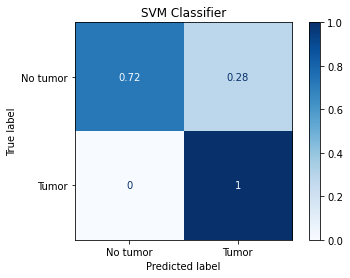

In [19]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.
        
    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
    {"kernel": ["rbf"], "gamma": ['scale', 'auto'], "C": [1, 10, 100]},
    {"kernel": ["poly"], "gamma": ['scale', 'auto'], "C": [1, 10, 100], "degree": [2, 3, 4]}
    ]
    
    matthews = metrics.make_scorer(metrics.matthews_corrcoef)
    scoring = {'AUC': 'roc_auc_ovr_weighted', 'matthews': matthews}
    
    # Create SVC object
    svc = svm.SVC(probability=True)
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(svc, 
                       parameters, 
                       scoring=scoring,
                       refit='matthews', # use matthews for refit due to imbalanced data
                       verbose=2,
                       return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)
    
    results = pd.DataFrame.from_dict(clf.cv_results_).sort_values(by=['rank_test_matthews'])
    results = results[['params', 'mean_train_AUC','mean_test_AUC', 'rank_test_AUC', 
                       'mean_train_matthews', 'mean_test_matthews', 'rank_test_matthews']]
    
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels = ['No tumor', 'Tumor']
    )
    ax.set_title('SVM Classifier')
    
    return Y_pred, results

Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)
# score_SVM = metrics.accuracy_score(y_test, Y_pred_SVM)
# print(f'SVM classifier score: %.3f' % (score_SVM*100))
# score_matthews_SVM = metrics.matthews_corrcoef(y_test, Y_pred_SVM)
# print(f'SVM classifier Matthews score: %.3f' % (score_matthews_SVM*100))

# precision is the ability of the classifier not to label as positive a sample that is negative
# recall is the ability of the classifier to find all the positive samples
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# support is the number of occurrences of each class in y_test
print(metrics.classification_report(y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
display(results_SVM)

Fitting 5 folds for each of 51 candidates, totalling 255 fits
{'n_neighbors': 1}
              precision    recall  f1-score   support

    No tumor       0.94      0.90      0.92       409
       Tumor       0.95      0.97      0.96       764

    accuracy                           0.95      1173
   macro avg       0.94      0.94      0.94      1173
weighted avg       0.95      0.95      0.95      1173



,params,mean_train_AUC,mean_test_AUC,rank_test_AUC,mean_train_matthews,mean_test_matthews,rank_test_matthews
0,{'n_neighbors': 1},1.000000,0.950172,7,1.000000,0.902659,1
1,{'n_neighbors': 2},0.998830,0.956456,2,0.954403,0.866662,2
2,{'n_neighbors': 3},0.995939,0.957083,1,0.923762,0.815059,3
3,{'n_neighbors': 4},0.991907,0.954200,3,0.886303,0.796276,4
4,{'n_neighbors': 5},0.987508,0.953591,4,0.850152,0.778257,5
5,{'n_neighbors': 6},0.983392,0.953561,5,0.833495,0.772016,6
7,{'n_neighbors': 8},0.977193,0.949846,8,0.800228,0.754964,7
6,{'n_neighbors': 7},0.980026,0.951847,6,0.803693,0.753495,8
8,{'n_neighbors': 9},0.974323,0.948826,9,0.780831,0.740582,9
9,{'n_neighbors': 10},0.971727,0.948162,10,0.781061,0.739609,10


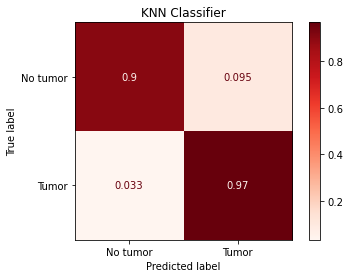

In [22]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        
    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters ={'n_neighbors': range(1, math.floor(math.sqrt(X_train.shape[1])), 1)}
    
    matthews = metrics.make_scorer(metrics.matthews_corrcoef)
    scoring = {'AUC': 'roc_auc_ovr_weighted', 'matthews': matthews}
    
    # Create KNN object
    neigh = KNeighborsClassifier(algorithm='auto')
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(neigh, 
                       parameters, 
                       scoring=scoring,
                       refit='matthews', # use matthews for refit due to imbalanced data
                       verbose=1,
                       return_train_score=True)
    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)
    
    results = pd.DataFrame.from_dict(clf.cv_results_).sort_values(by=['rank_test_matthews'])
    results = results[['params', 'mean_train_AUC','mean_test_AUC', 'rank_test_AUC', 
                       'mean_train_matthews', 'mean_test_matthews', 'rank_test_matthews']]
    
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)
    
    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Reds,
        normalize='true',
        ax=ax,
        display_labels = ['No tumor', 'Tumor']
    )
    ax.set_title('KNN Classifier')
    
    return Y_pred, results


Y_pred_KNN, results_KNN = KNNClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(y_test, Y_pred_KNN, target_names=['No tumor', 'Tumor']))
display(results_KNN)

In [16]:
# def RFClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset;
#         k: Number of trees in the forest.
        
#     Return
#         Y_pred: Predicted labels from X_test using Random Forests.
#     '''
#     # Create dictionary of parameters to cross validate the estimator on
#     parameters = {'n_estimators':[100, 200, 300], 'criterion':['entropy', 'gini'],
#     'max_features': ['sqrt', 'log2']}
#     # Create Random Forest object
#     RF = RandomForestClassifier()
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(RF, parameters, scoring='accuracy')
#     # Fit RF model with the parameters for cross-validation
#     clf.fit(X_train, y_train) 
#     print(clf.best_params_)
#     # Predict labels with the best parameters from cross-validation
#     Y_pred = clf.predict(X_test)

#     disp = metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         cmap=plt.cm.Greens,
#         normalize='true'
#     )
#     disp.ax_.set_title('Random Forest Classifier')
    
#     return Y_pred, disp

# Y_pred_RandomForest, disp_RF = RFClassifierCV(X_train, y_train, X_test)
# score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
# print('Random Forest classifier score:', score_RandomForest)

In [17]:
# def LSVMClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset.
        
#     Return
#         Y_pred: Predicted labels from X_test using SVM.
#     '''

#     # Create dictionary of parameters to cross validate the estimator on
#     # linear was considered in another function as kernel='linear' took very long to compute
#     parameters = {"loss": ['hinge', 'squared_hinge'], "C": [1, 10, 100]}

#     # Create SVC object
#     svc = svm.LinearSVC(dual=False)
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(svc, parameters, scoring='accuracy', n_jobs=-2, error_score=0.0)
#     # Fit SVC model with the parameters for cross-validation
#     clf.fit(X_train, y_train)
#     # Predict labels with the best parameters from cross-validation
#     print(clf.best_params_)

#     clf.fit(X_train, y_train)
    
#     Y_pred = clf.predict(X_test)

#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#     fig.suptitle('Linear SVM Classifier')
#     axs[0].set_title('Train')
#     axs[1].set_title('Test')
#     metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_train,
#         y_train,
#         cmap=plt.cm.Blues,
#         normalize='true',
#         ax = axs[0],
#         display_labels = ['No tumor', 'Tumor'],
#         colorbar = False
#     )
#     metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         cmap=plt.cm.Blues,
#         normalize='true',
#         ax = axs[1],
#         display_labels = ['No tumor', 'Tumor'],
#         colorbar = False
#     )
    
#     return Y_pred

# Y_pred_LSVM = LSVMClassifierCV(X_train, y_train, X_test)
# score_LSVM = metrics.accuracy_score(y_test, Y_pred_LSVM)
# print('LSVM classifier score:', score_LSVM)